In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, digamma, gammaln
from scipy.spatial import distance
from collections import defaultdict


def set_param_for_priors(data, K):
    def gen_epsilon_k(u_0, sigma):
        return np.random.multivariate_normal(u_0, sigma).reshape(2, 1)

    alpha_0 = D+1
    beta_0 = D+1
    nu_0 = D+1

    u_0 = data.mean(axis=0).reshape(2, 1) # D×1
    deviation = data.T - u_0 # D×N
    V_0 = np.linalg.inv((nu_0/N)*np.dot(deviation, deviation.T)) # D×D

    sigma  = np.linalg.inv(beta_0*nu_0*V_0)
    epsilon = np.array([gen_epsilon_k(u_0.flatten(), sigma) for k in range(K)]) # K×D×1

    return alpha_0, beta_0, nu_0, u_0, V_0, epsilon


def run_VB(X, K, alpha_0, beta_0, nu_0, u_0, V_0, epsilon, n_iter=50):
    # K×1
    alpha = np.ones(shape=(K, 1))*alpha_0 # dirichlet
    beta = np.ones(shape=(K, 1))*beta_0 # gauss-wishart
    nu = np.ones(shape=(K, 1))*nu_0 # gauss-wishart
    eta = np.zeros(shape=(K, 1))

    # N×K
    rho = np.zeros((N, K))
    r = np.zeros((N, K))
    u = epsilon.copy()

    # K×D×D
    V = np.array([V_0 for k in range(K)]) # gauss-wishart

    # 更新
    for _ in range(n_iter):
        rho = update_rho(rho, u, alpha, beta, nu, V, X, K) # N×K
        r = rho/rho.sum(axis=1).reshape(N, 1) # N×K
        eta = r.sum(axis=0).reshape(K, 1) # K×1
    
        alpha = alpha_0 + eta
        beta = beta_0 + eta
        nu = nu_0 + eta
        u = update_u(u, u_0, beta_0, beta, r, X, K)
        V = update_V(V, u_0, u, r, X, K)

    return alpha, beta, nu, r, u, V


def update_rho(rho, u, alpha, beta, nu, V, X, K):
    for n in range(N):
        x_n = X[n].reshape(2, 1)
        for k in range(K):
            u_k = u[k].reshape(2, 1)
            tmp_1 = digamma(alpha[k])
            tmp_2 = np.sum([digamma((nu[k]+1-d)/2) for d in range(1, D+1)])
            tmp_3 = math.log(np.linalg.det(V[k]))
            tmp_4 = -D / beta[k]
            tmp_5 = -nu[k]*((x_n-u_k).T)@V[k]@(x_n-u_k)
            rho[n, k] = np.exp(tmp_1+(1/2)*(tmp_2+tmp_3+tmp_4+tmp_5))

    return rho


def update_u(u, u_0, beta_0, beta, r, X, K):
    for k in range(K):
        u_k = u[k]
        tmp = np.zeros((D, 1))
        for n in range(N):
            x_n = X[n].reshape(2, 1)
            tmp += r[n, k]*x_n
        u[k] = ((beta_0*u_0)+tmp) / beta[k]

    return u


def update_V(V, u_0, u, r, X, K, ):
    for k in range(K):
        u_k = u[k]
        tmp = np.zeros((D, D))
        for n in range(N):
            x_n = X[n].reshape(2, 1)
            tmp += r[n, k]*(x_n-u_k)@((x_n-u_k).T)
        V[k] = np.linalg.inv(np.linalg.inv(V_0)+beta_0*(u_k-u_0)@((u_k-u_0).T)+tmp)

    return V

In [2]:
# 多変量ガンマ関数の対数
def gammaln_D(x, D):
    val1 = (D*(D-1)/4) * math.log(math.pi)
    val2 = sum([gammaln(x-((d-1)/2)) for d in range(1, D+1)])

    return val1 + val2


# 混合数選択基準
def calc_criteria(K, alpha_0, beta_0, nu_0, V_0, alpha, beta, nu, r, V):
    term_1 = gammaln(K*alpha_0+N)-gammaln(K*alpha_0)

    term_2 = 0
    for n in range(N):
        for k in range(K):
            term_2 += r[n, k]*math.log(r[n, k]) if r[n, k] != 0 else 0

    term_3 = 0
    for k in range(K):
        tmp_1 = gammaln(alpha_0) + gammaln_D(nu_0/2, D) - gammaln(alpha[k]) - gammaln_D(nu[k]/2, D)
        tmp_2 = (1/2)*(nu_0*math.log(np.linalg.det(V_0)) - nu[k]*math.log(np.linalg.det(V[k])) + \
               D*(math.log(beta[k]) - math.log(beta_0)))
        term_3 += (tmp_1 + tmp_2)

    return term_1 + term_2 + term_3

## ① 混合数の点推定

In [3]:
data = pd.read_table("data/GaussianMixtureData20130501.txt").values
N, D = data.shape # データ数, 次元数
max_K = 10

res_dic = defaultdict(dict)
for K in range(1, max_K+1):
    alpha_0, beta_0, nu_0, u_0, V_0, epsilon = set_param_for_priors(data, K)
    alpha, beta, nu, r, u, V = run_VB(data, K, alpha_0, beta_0, nu_0, u_0, V_0, epsilon, n_iter=50)

    criteria = calc_criteria(K, alpha_0, beta_0, nu_0, V_0, alpha, beta, nu, r, V)[0]
    w = alpha/alpha.sum()
    mu = u.copy()
    sigma = [np.linalg.inv(nu[k]*V[k]) for k in range(K)]

    res_dic[K]["w"] = w
    res_dic[K]["mu"] = mu
    res_dic[K]["sigma"] = sigma
    res_dic[K]["criteria"] = criteria

    print(f"K={K}: criteria: {criteria}")

K=1: criteria: 11445.329081279771
K=2: criteria: 11013.27194676789
K=3: criteria: 10889.215255128129
K=4: criteria: 10902.936800982108
K=5: criteria: 10915.19758656623
K=6: criteria: 10927.3892590104
K=7: criteria: 10945.714475822373
K=8: criteria: 10978.333734589254
K=9: criteria: 10965.010343909118
K=10: criteria: 11026.169765320981


## ② 事後平均解

In [4]:
K_hat = np.argmin([res_dic[k]["criteria"] for k in range(1, max_K+1)]) + 1
w = res_dic[K_hat]["w"]
mu = res_dic[K_hat]["mu"]
sigma = res_dic[K_hat]["sigma"]

for k in range(K_hat):
    print(f"----- 分布 {k+1} -----")
    print(f"混合率: \n", w[k][0])
    print("平均: \n", mu[k].flatten())
    print("共分散: \n", sigma[k])
    print()

----- 分布 1 -----
混合率: 
 0.26772263084442893
平均: 
 [ 1.17914002 -0.6271253 ]
共分散: 
 [[970.37553969  13.80795704]
 [ 13.80795704 107.77198781]]

----- 分布 2 -----
混合率: 
 0.46469406488172466
平均: 
 [39.79430761 -0.13897214]
共分散: 
 [[ 113.72734766  192.08750341]
 [ 192.08750341 1562.73680599]]

----- 分布 3 -----
混合率: 
 0.2675833042738464
平均: 
 [-38.40104014  17.1115536 ]
共分散: 
 [[149.57495591 -26.10938153]
 [-26.10938153 936.11027226]]



## ③ 推定結果描画

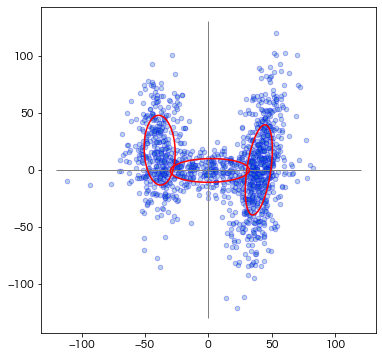

In [5]:
plt.figure(figsize=(6, 6))
plt.hlines(y=0, xmin=-120, xmax=120, color="gray", linewidths=1)
plt.vlines(x=0, ymin=-130, ymax=130, color="gray", linewidths=1)
plt.scatter(data[:, 0], data[:, 1], s=20, alpha=0.3, linewidths=1, edgecolors="b")
for k in range(K_hat):
    mahalanobis_k = np.array(
        [
            [
                (i, j, distance.mahalanobis([i, j], mu[k], np.linalg.inv(sigma[k]))) 
                for i in np.linspace(-100, 100, 1000)
            ]
            for j in np.linspace(-100, 100, 1000)
        ]
    )
    plt.contour(
        mahalanobis_k.transpose()[0],
        mahalanobis_k.transpose()[1],
        mahalanobis_k.transpose()[2],
        levels=[1],
        colors=['r']
    )
plt.show()